In [415]:
import itertools
from collections import defaultdict 

import pandas as pd
import numpy as np
import utils 
import pickle

import tensorflow as tf 

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB 

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from keras.models import model_from_json
from keras.optimizers import Adam
from keras.metrics import categorical_accuracy

from lstm_classifier import TextLSTM
from conv_classifier import TextCNN 

import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [61]:
train_data = pd.read_csv('data/processed_data/training_cases.csv')
val_data = pd.read_csv('data/processed_data/validation_cases.csv')
test_data = pd.read_csv('data/processed_data/test_cases.csv')

train_labels = list(train_data['convote'])
train_topics = list(train_data['geniss1'])

val_labels = list(val_data['convote'])
val_topics = list(val_data['geniss1'])

test_labels = list(test_data['convote'])
test_topics = list(test_data['geniss1'])

In [27]:
all_train_cases = utils.get_all_cases(train_data['caseid'])
all_val_cases = utils.get_all_cases(val_data['caseid'])
all_test_cases = utils.get_all_cases(test_data['caseid'])

In [6]:
additional_features = ['caseid', 'Affirmed', 'AffirmedInPart', 'Reversed', 'ReversedInPart', 
                      'Vacated', 'VacatedInPart', 'Remanded']
train_additional = train_data[additional_features]
val_additional = val_data[additional_features]
test_additional = test_data[additional_features]

In [63]:
topic = 7
train_corpus, labels_train, train_ids = utils.build_corpus(all_train_cases, 
                                                train_labels, 
                                                train_topics,
                                                topic_filter=topic)
val_corpus, labels_val, val_ids = utils.build_corpus(all_val_cases, 
                                        val_labels, 
                                        val_topics,
                                        topic_filter=topic)

train_add = train_additional[train_additional['caseid'].isin(train_ids)].iloc[:,1:].as_matrix()
val_add = val_additional[val_additional['caseid'].isin(val_ids)].iloc[:, 1:].as_matrix() 

train_ngrams, vectorizer = utils.load_ngrams(train_corpus, 
                                             ngram_range=(1,3), 
                                             tfidf=True, 
                                             max_features=50000)
val_ngrams = vectorizer.transform(val_corpus)

train_ngrams = train_ngrams.todense() 
val_ngrams = val_ngrams.todense() 
print(train_ngrams.shape, val_ngrams.shape)
train_ngrams = np.concatenate((train_ngrams, train_add), axis=1)
val_ngrams = np.concatenate((val_ngrams, val_add), axis=1) 
print(train_ngrams.shape, val_ngrams.shape)

Num Cases: 2693, Num Labels: 2693
Num Cases: 398, Num Labels: 398
(2693, 32299) (398, 32299)
(2693, 32306) (398, 32306)


Normalized confusion matrix
[[0.51075269 0.40566038]
 [0.48924731 0.59433962]]


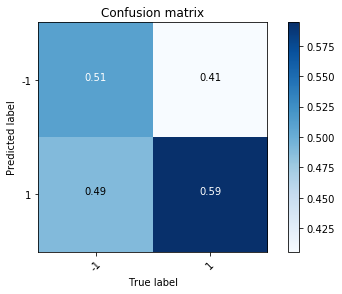

In [292]:
print('LOGISTIC')
log = LogisticRegression(penalty='l1', class_weight='balanced', random_state=0)
log.fit(train_ngrams, train_labels)
train_accuracy = log.score(train_ngrams, train_labels)
val_accuracy = log.score(val_ngrams, val_labels)
val_pred = log.predict(val_ngrams)

print('Logistic Train Accuracy:', train_accuracy)
print('Logistic Val Accuracy:', val_accuracy) 
plt.figure() 
utils.plot_confusion_matrix(val_pred, val_labels, title='Logistic Topic {}'.format(topic))

print('RANDOM FOREST')
forest = RandomForestClassifier(n_estimators=20, n_jobs=4, random_state=0, class_weight={-1:1, 1:1.5})
forest.fit(train_ngrams, train_labels)
train_accuracy = forest.score(train_ngrams, train_labels)
val_accuracy = log.score(val_ngrams, val_labels)
val_pred = log.predict(val_ngrams)
print('Random Forest Train Accuracy:', train_accuracy)
print('Random Forest Val Accuracy:', val_accuracy) 
plt.figure() 
utils.plot_confusion_matrix(val_pred, val_labels, title='Random Forest Topic {}'.format(topic))
    
print('SVM')
svm = SVC(C=0.8, kernel='linear', class_weight='balanced', random_state=0)
svm.fit(train_ngrams, train_labels)
train_accuracy = svm.score(train_ngrams, train_labels)
val_accuracy = svm.score(val_ngrams, val_labels)
val_pred = svm.predict(val_ngrams)

print('SVM Train Accuracy:', train_accuracy)
print('SVM Val Accuracy:', val_accuracy)
plt.figure() 
utils.plot_confusion_matrix(val_pred, val_labels,  title='SVM Topic {}'.format(topic))

print('Gradient Boosting')
gradboost = GradientBoostingClassifier(random_state=0)
gradboost.fit(train_ngrams, labels_train)
train_acc = gradboost.score(train_ngrams, labels_train)
val_acc = gradboost.score(val_ngrams, labels_val)
gradboost_val_pred = gradboost.predict(val_ngrams)

utils.plot_confusion_matrix(gradboost_val_pred, labels_val)

Naive Bayes
Train Acc: 0.9851466765688823
Val Acc: 0.5728643216080402
Normalized confusion matrix
[[0.59677419 0.44811321]
 [0.40322581 0.55188679]]


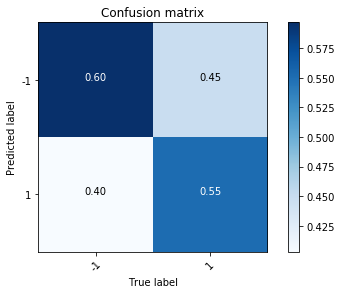

In [340]:
print('Gaussian Naive Bayes')
gnb = GaussianNB(priors=[.49, .51])
gnb.fit(train_ngrams, labels_train)
print('Train Acc:', gnb.score(train_ngrams, labels_train))
print('Val Acc:', gnb.score(val_ngrams, labels_val))

gnb_predict = gnb.predict(val_ngrams)
utils.plot_confusion_matrix(gnb_predict, labels_val)

Bernoulli Naive Bayes
Train Acc: 0.8076494615670257
Val Acc: 0.5954773869346733
Normalized confusion matrix
[[0.45698925 0.28301887]
 [0.54301075 0.71698113]]


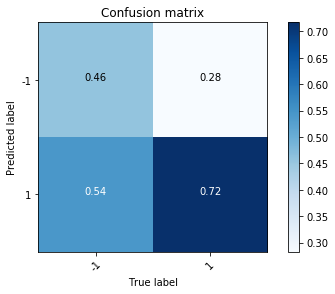

In [341]:
print('Bernoulli Naive Bayes')
nb = BernoulliNB(class_prior=[.49, .51])
nb.fit(train_ngrams, labels_train)
print('Train Acc:', nb.score(train_ngrams, labels_train))
print('Val Acc:', nb.score(val_ngrams, labels_val))

nb_predict = nb.predict(val_ngrams)
utils.plot_confusion_matrix(nb_predict, labels_val)

In [342]:
# Save models 
# with open('final_sklearn_model/logistic.p', 'wb') as p: 
#     pickle.dump(log, p)
    
# with open('final_sklearn_model/forest.p', 'wb') as p: 
#     pickle.dump(forest, p)
    
# with open('final_sklearn_model/svm.p', 'wb') as p: 
#     pickle.dump(svm, p)

# Weighted with {-1: 1.2, 1:1}
# with open('final_sklearn_model/logistic-weighted.p', 'wb') as p: 
#     pickle.dump(log, p)

# with open('final_sklearn_model/gradientboost.p', 'wb') as p: 
#     pickle.dump(gradboost, p)

# with open('final_sklearn_model/naivebayes.p', 'wb') as p: 
#     pickle.dump(nb, p)
    
with open('final_sklearn_model/bernoulli-naivebayes.p', 'wb') as p: 
    pickle.dump(nb, p)

In [64]:
vocab = vectorizer.vocabulary_
len(vocab.keys())

32299

In [558]:
tri_log_coef = log.coef_.squeeze()
tri_svm_coef = svm.coef_.squeeze()
print(len(tri_log_coef), len(tri_svm_coef))

vocab_trigrams = vectorizer.vocabulary_
print(len(vocab_trigrams.keys()))

32306 32306
32299


In [559]:
tri_log_sorted = np.argsort(tri_log_coef)
top_tri_log_neg = tri_log_sorted[:30]
for i in top_tri_log_neg: 
    print(i, [(k, tri_log_coef[v]) for k, v in vocab_trigrams.items() if v==i])

29760 [('tax', -3.6146938692757278)]
11660 [('ct', -2.8208974352823653)]
0 [('00', -2.5906389052903607)]
10738 [('cost', -2.2791145579361825)]
29958 [('taxpayers', -2.1835385742758775)]
13578 [('distribution', -2.0427502211841917)]
10480 [('contributory negligence', -1.930151880407138)]
29916 [('taxpayer', -1.8464079089901193)]
19466 [('jury', -1.7480647448619142)]
19182 [('jones', -1.7112017996625042)]
17839 [('housing', -1.5595500629033627)]
6412 [('association', -1.4132147946825038)]
30824 [('trust', -1.304889501638045)]
27503 [('section', -1.2045708532821848)]
11575 [('credit', -1.1597632089471883)]
23401 [('petitioner', -0.9984388261010322)]
14012 [('dr', -0.9855491000778777)]
19142 [('jersey', -0.9348780538325605)]
27423 [('seaman', -0.854759644052322)]
25559 [('reasonable', -0.8223166916176243)]
32068 [('work', -0.48751973742433136)]
24682 [('property', -0.4021253793230173)]
32304 []
12401 [('defendant', -0.3975717764013384)]
32300 []
7043 [('bell', -0.3288229337060443)]
32299 [

In [560]:
tri_svm_sorted = np.argsort(tri_svm_coef)
top_tri_svm_neg = tri_svm_sorted[:30]
for i in top_tri_svm_neg: 
    print([(k, tri_svm_coef[v]) for k, v in vocab_trigrams.items() if v==i])

[('tax', -2.080718627582566)]
[('jones', -1.6858657519661384)]
[('credit', -1.4591534613257915)]
[('00', -1.4296315472973802)]
[('seaman', -1.374634897367903)]
[('dust', -1.3733450260908056)]
[('housing', -1.3571424893546788)]
[('dr', -1.3333587357417882)]
[('jury', -1.3130704272256808)]
[('section', -1.2792979813900713)]
[('ferc', -1.2761441638438316)]
[('work', -1.2646808758526695)]
[('bell', -1.2343018719759677)]
[('reasonable', -1.2292298381925935)]
[('jersey', -1.22083994129534)]
[('taxpayer', -1.1880697093418568)]
[('callahan', -1.185320569184001)]
[('ct', -1.1834883168851373)]
[('trust', -1.1769267923933007)]
[('western', -1.1551721582701555)]
[('distribution', -1.1540478805508723)]
[('new jersey', -1.144581506633449)]
[('finance', -1.1211050181175537)]
[('taxpayers', -1.1108856914671845)]
[('stone', -1.0940200049897872)]
[('cost', -1.0791490746167574)]
[('cup', -1.0577346766153375)]
[('capacity', -1.0266975477955456)]
[('hearing examiner', -1.018426087345484)]
[('contributory n

In [561]:
top_tri_log_pos = tri_log_sorted[-30:][::-1]
for i in top_tri_log_pos: 
    print(i, [(k, tri_log_coef[v]) for k, v in vocab_trigrams.items() if v==i])

8882 [('claims', 3.861915507548691)]
18291 [('indictment', 2.535991917294167)]
5911 [('appellee', 1.2314882752338792)]
7302 [('breach', 1.1081256303378089)]
18851 [('invention', 1.1036522030886473)]
9401 [('community', 0.90746448372135)]
22980 [('patent', 0.8917366632413944)]
23645 [('plaintiffs', 0.8881861061313848)]
21384 [('motion', 0.8016775600330318)]
22922 [('partnership', 0.6572896918202555)]
31126 [('united states', 0.6155471012634534)]
18644 [('insured', 0.6108917599133257)]
5297 [('air', 0.318816588364075)]
32303 []
23786 [('policy', 0.25442564426591546)]
6778 [('bankruptcy', 0.2340938141676465)]
32302 []
10790 [('counterclaim based', 0.0)]
10787 [('counted', 0.0)]
10789 [('counterclaim', 0.0)]
10791 [('counterclaimed', 0.0)]
10785 [('count ii', 0.0)]
10786 [('count indictment', 0.0)]
10788 [('counter', 0.0)]
16152 [('filed amended complaint', 0.0)]
10792 [('counterclaims', 0.0)]
10793 [('countered', 0.0)]
10795 [('countervailing', 0.0)]
10796 [('counties', 0.0)]
10797 [('cou

In [562]:
top_tri_svm_pos = tri_svm_sorted[-30:][::-1]
for i in top_tri_svm_pos: 
    print([(k, tri_svm_coef[v]) for k, v in vocab_trigrams.items() if v==i])

[('appellee', 1.5546639692148292)]
[('indictment', 1.457595604932184)]
[('claims', 1.4171433903835333)]
[('community', 1.3758050170678051)]
[('plaintiffs', 1.3417893730329304)]
[('rates', 1.2206557977140904)]
[('club', 1.1432498612070119)]
[('conspiracy', 1.106423526429754)]
[('contempt', 1.0955990507994324)]
[('roberts', 1.0753100972680911)]
[('employee', 1.0450784320746842)]
[('american', 1.033779840351442)]
[('farm', 1.0239428357019318)]
[('insured', 1.0169911102363298)]
[('sisters', 1.0168898685759087)]
[('breach', 1.0057056600286576)]
[('debenture', 0.9937493091015057)]
[('directors', 0.9864456135410555)]
[('tracks', 0.9650185631369366)]
[('river', 0.9583963791029338)]
[('18', 0.9314511818240491)]
[('se', 0.9176415357835926)]
[('month', 0.9063695853320073)]
[('maxwell', 0.8982722206148707)]
[('conviction', 0.8971193834802431)]
[('minnesota', 0.8921626434201124)]
[('alleged', 0.8888225726408735)]
[('dunn', 0.8879960969222144)]
[('barnett', 0.868515581551395)]
[('loan', 0.8662522078

In [553]:
tri_log_pos = [k for k, v in vocab_trigrams.items() if v in top_tri_log_pos and tri_log_coef[v] > 0.0]
tri_log_neg = [k.split(' ') for k, v in vocab_trigrams.items() if v in top_tri_log_neg and tri_log_coef[v] < 0.0]
tri_log_neg = list(itertools.chain(*tri_log_neg))

tri_svm = [k.split(' ') for k, v in vocab_trigrams.items() if abs(tri_svm_coef[v]) > 0.2]
tri_svm = list(itertools.chain(*tri_svm))

In [ ]:
filtered_vocab = list(set(tri_log_pos + tri_log_neg + tri_svm))
with open('data/processed_data/filtered_vocab.p', 'wb') as p: 
    pickle.dump(filtered_vocab, p)
len(filtered_vocab)

In [38]:
with open('data/processed_data/filtered_vocab.p', 'rb') as p: 
    filtered_vocab = pickle.load(p)

In [554]:
filtered_vocab

['reversible',
 '947',
 'food',
 'stating',
 'ride',
 'issuer',
 'heart',
 'tel',
 'bap',
 'durham',
 'modification',
 'dam',
 'wired',
 'passed',
 'parker',
 '411',
 '1915',
 'occasion',
 'underwriters',
 'salvage',
 'decedent',
 'tie',
 'periods',
 '300',
 'warehouse',
 'aspects',
 'miner',
 'hospital',
 'short',
 '522',
 'implicitly',
 'chase',
 'believed',
 'spouses',
 'beneficiary',
 'ninety',
 'chairman',
 'authorities',
 'neighborhood',
 'concrete',
 'chambers',
 'textile',
 'assured',
 'issue',
 '26',
 'steel',
 'reimbursement',
 'architect',
 'makes',
 'license',
 'prepare',
 'applies',
 'nichols',
 'burnet',
 'progress',
 'plea',
 'beach',
 '1943',
 'showed',
 'reprinted',
 'baggage',
 'effectuate',
 'conscious',
 'fuller',
 'edges',
 'resources',
 'virgin',
 'reissue',
 '67',
 'chain',
 'seq',
 'serve',
 'winter',
 'mary',
 'heirs',
 'norton',
 'additional',
 'fatal',
 'delaware',
 'york',
 'basin',
 'monopolization',
 'rope',
 'subsection',
 'manufacturers',
 'merchants',
 

# Data Preprocess for LSTM 

In [69]:
topic = 7
# Create vocabulary dictionary from filtered vocab 
word_index = defaultdict(int)
idx = 1
for word in filtered_vocab: 
    word_index[word] = idx
    idx += 1 

train_corpus, labels_train, train_ids = utils.build_corpus(all_train_cases, 
                                                train_labels, 
                                                train_topics,
                                                topic_filter=topic)

val_corpus, labels_val, val_ids = utils.build_corpus(all_val_cases, 
                                        val_labels, 
                                        val_topics,
                                        topic_filter=topic)
test_corpus, labels_test, test_ids = utils.build_corpus(all_test_cases, 
                                        test_labels, 
                                        test_topics,
                                        topic_filter=topic)

train_add = train_additional[train_additional['caseid'].isin(train_ids)].iloc[:,1:].as_matrix()
val_add = val_additional[val_additional['caseid'].isin(val_ids)].iloc[:, 1:].as_matrix() 
test_add = test_additional[test_additional['caseid'].isin(test_ids)].iloc[:, 1:].as_matrix() 

Num Cases: 2693, Num Labels: 2693
Num Cases: 398, Num Labels: 398
Num Cases: 404, Num Labels: 404


In [70]:
def map_corpus_to_int(word_index, corpus):
    int_corpus = [np.array([word_index[word] for word in doc.split(' ')
                            if word in word_index.keys()]) for doc in corpus]
    return int_corpus

int_train_corpus = map_corpus_to_int(word_index, train_corpus)
int_val_corpus = map_corpus_to_int(word_index, val_corpus)
int_test_corpus = map_corpus_to_int(word_index, test_corpus)

vocab_size = max([max(i) for i in int_train_corpus])

(array([155., 586., 617., 475., 329., 197., 120.,  68.,  45.,  31.,  25.,
          8.,   9.,   9.,   5.,   5.,   1.,   4.,   1.,   3.]),
 array([  12. ,  206.1,  400.2,  594.3,  788.4,  982.5, 1176.6, 1370.7,
        1564.8, 1758.9, 1953. , 2147.1, 2341.2, 2535.3, 2729.4, 2923.5,
        3117.6, 3311.7, 3505.8, 3699.9, 3894. ]),
 <a list of 20 Patch objects>)

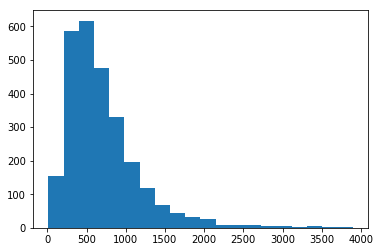

In [71]:
seq_lengths = [len(i) for i in int_train_corpus]
plt.hist(seq_lengths, bins=20)

In [72]:
def one_hot(labels):
    labels = [0 if y==-1. else 1 for y in labels]
    return utils.one_hot_labels(labels)

train_y = one_hot(labels_train)
val_y = one_hot(labels_val)
test_y = one_hot(labels_test)

# LSTM Train 

In [73]:
vocab_size = max([max(i) for i in int_train_corpus]) + 1 
seq_length = round(.8* max(seq_lengths)) 
print('Sequence Length:', seq_length)
lr = .00005
epochs = 50
batch_size = 32
num_classes = 2
embed_size = 100
num_units = 128
dropout_prob = 0.5

geniss = 7

metadata_path = 'tf_logs/metadata.tsv'

int_train_corpus = np.vstack([utils.trim_and_pad(doc, seq_length) for doc in int_train_corpus])
int_val_corpus = np.vstack([utils.trim_and_pad(doc, seq_length) for doc in int_val_corpus])

Sequence Length: 3115


In [21]:
lstm = TextLSTM(vocab_size=vocab_size, embedding_size=embed_size,
                dropout=dropout_prob, seq_length=seq_length, lr=lr,
                num_units=num_units, num_classes=num_classes)

val_pred = lstm.train(train_x=int_train_corpus, train_y=train_y,
                      train_add_x=train_add, val_add_x=val_add,
                      val_x=int_val_corpus, val_y=val_y,
                      batch_size=batch_size, epochs=epochs,
                      geniss=geniss, embed_metadata=metadata_path)

Normalized confusion matrix
[[0.53225806 0.35849057]
 [0.46774194 0.64150943]]


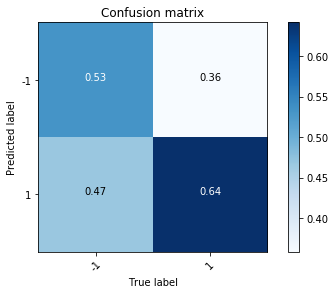

In [26]:
pred = np.argmax(val_pred, 1)
truth = np.argmax(val_y, 1)
utils.plot_confusion_matrix(pred, truth)

# CNN Train 

In [53]:
filter_sizes = [1,2,3]
filters = 32 
num_classes = 2
learning_rate = .00002
reg_lambda = 0.02 
embedding_size = 100 
dropout_prob = 0.5
metadata_path = 'tf_logs/metadata.tsv'

epochs = 30

cnn = TextCNN(filter_sizes, filters, num_classes,
              reg_lambda, learning_rate, vocab_size, 
              seq_length, embedding_size)

cnn_val_pred = cnn.train(train_x=int_train_corpus, train_y=train_y, 
          val_x=int_val_corpus, val_y=val_y,
          train_add=train_add, val_add=val_add, 
          keep_prob=dropout_prob, geniss=geniss, 
          metadata_path=metadata_path,
          batch_size=batch_size, epochs=epochs)

Created 85 batches of length 32
Conv 0 (?, 3115, 1, 32)
Pooled 0 (?, 1, 1, 32)
Conv 1 (?, 3114, 1, 32)
Pooled 1 (?, 1, 1, 32)
Conv 2 (?, 3113, 1, 32)
Pooled 2 (?, 1, 1, 32)
Flatted:  (?, 96)
Concat: (?, 103)
Dropout: (?, 103)
Logits:  (?, 2)
Epoch 0 Mean Train Acc 0.499044 Validation Accuracy: 0.507538
Epoch 1 Mean Train Acc 0.512059 Validation Accuracy: 0.522613
Epoch 2 Mean Train Acc 0.536691 Validation Accuracy: 0.535176
Epoch 3 Mean Train Acc 0.561691 Validation Accuracy: 0.532663
Epoch 4 Mean Train Acc 0.578603 Validation Accuracy: 0.542714
Epoch 5 Mean Train Acc 0.589265 Validation Accuracy: 0.540201
Epoch 6 Mean Train Acc 0.612132 Validation Accuracy: 0.540201
Epoch 7 Mean Train Acc 0.617500 Validation Accuracy: 0.550251
Epoch 8 Mean Train Acc 0.627794 Validation Accuracy: 0.557789
Epoch 9 Mean Train Acc 0.640074 Validation Accuracy: 0.565327
Epoch 10 Mean Train Acc 0.644853 Validation Accuracy: 0.567839
Epoch 11 Mean Train Acc 0.654044 Validation Accuracy: 0.572864
Epoch 12 Mea

# Test

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 3115)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 3115, 100)    355700      main_input[0][0]                 
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 3115, 128)    117248      embedding_3[0][0]                
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 128)          131584      lstm_5[0][0]                     
__________________________________________________________________________________________________
aux_input 

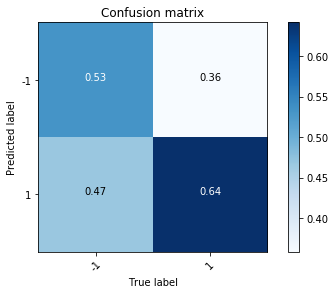

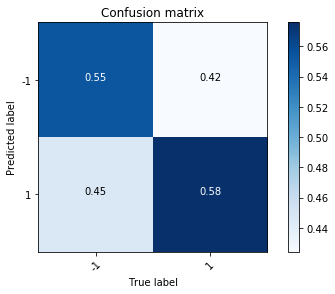

In [74]:
json_file = open('final_lstm_model/model-128-5e-05.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

int_test_corpus = np.vstack([utils.trim_and_pad(doc, seq_length) for doc in int_test_corpus])
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('final_lstm_model/geniss7-acc0.589196-lr0.000050-units128.h5')

# New learning rate 
lr = 0.000005
adam = Adam(lr=lr)
# compile loaded model 
loaded_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', categorical_accuracy])

print(loaded_model.summary())
val_predictions = loaded_model.predict({'main_input': int_val_corpus, 'aux_input': val_add})
test_predictions = loaded_model.predict({'main_input': int_test_corpus, 'aux_input': test_add})

plt.figure() 
val_pred = np.argmax(val_predictions, 1)
val_truth = np.argmax(val_y, 1)
utils.plot_confusion_matrix(val_pred, val_truth)

plt.figure() 
test_pred = np.argmax(test_predictions, 1)
test_truth = np.argmax(test_y, 1)
utils.plot_confusion_matrix(test_pred, test_truth)

INFO:tensorflow:Restoring parameters from final_cnn_model/7/geniss7-acc0.600503-lr2e-05
Normalized confusion matrix
[[0.44623656 0.26415094]
 [0.55376344 0.73584906]]
Accuracy 0.600503 Precision 0.735849 Recall 0.602317
Normalized confusion matrix
[[0.4368932  0.33333333]
 [0.5631068  0.66666667]]


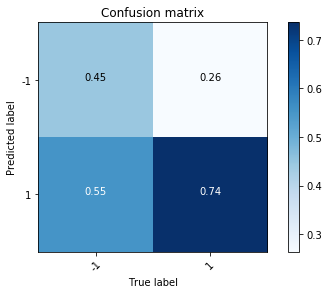

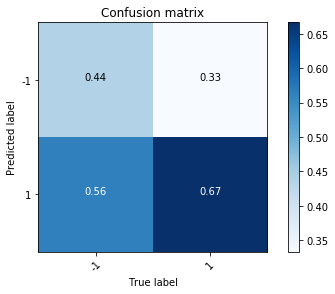

In [431]:
tf.reset_default_graph() 

int_test_corpus = np.vstack([utils.trim_and_pad(doc, seq_length) for doc in int_test_corpus])

with tf.Session() as sess: 
    saver = tf.train.import_meta_graph('final_cnn_model/7/geniss7-acc0.600503-lr2e-05.meta')
    saver.restore(sess, 'final_cnn_model/7/geniss7-acc0.600503-lr2e-05')
    x = sess.graph.get_tensor_by_name('inputs/input_x:0')
    add_x = sess.graph.get_tensor_by_name('inputs/add_x:0')
    prediction = sess.graph.get_tensor_by_name('prediction/ArgMax:0')
    val_predictions = sess.run(prediction, feed_dict={x: int_val_corpus, add_x: val_add})
    test_predictions = sess.run(prediction, feed_dict={x: int_test_corpus, add_x: test_add})

plt.figure() 
val_truth = np.argmax(val_y, 1)
utils.plot_confusion_matrix(val_predictions, val_truth)

val_predictions[val_predictions==0] = -1
val_accuracy = sklearn.metrics.accuracy_score(val_predictions, labels_val)
val_precision = sklearn.metrics.precision_score(val_predictions, labels_val)
val_recall =  sklearn.metrics.recall_score(val_predictions, labels_val)

print('Accuracy {:2f} Precision {:2f} Recall {:2f}'.format(val_accuracy, val_precision, val_recall))

plt.figure() 
test_truth = np.argmax(test_y, 1)
utils.plot_confusion_matrix(test_predictions, test_truth)

INFO:tensorflow:Restoring parameters from final_cnn_model/7/geniss7-acc0.582915-lr9e-06
Normalized confusion matrix
[[0.52150538 0.36320755]
 [0.47849462 0.63679245]]
Normalized confusion matrix
[[0.56796117 0.37373737]
 [0.43203883 0.62626263]]


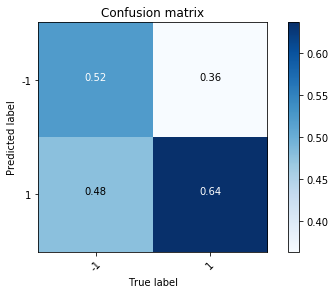

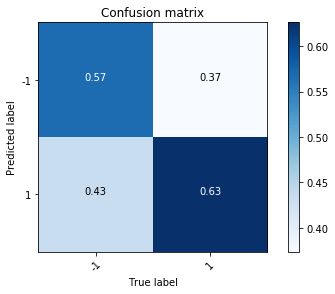

In [244]:
tf.reset_default_graph() 

int_test_corpus = np.vstack([utils.trim_and_pad(doc, seq_length) for doc in int_test_corpus])

with tf.Session() as sess: 
    saver = tf.train.import_meta_graph('final_cnn_model/7/geniss7-acc0.582915-lr9e-06.meta')
    saver.restore(sess, 'final_cnn_model/7/geniss7-acc0.582915-lr9e-06')
    x = sess.graph.get_tensor_by_name('inputs/input_x:0')
    add_x = sess.graph.get_tensor_by_name('inputs/add_x:0')
    prediction = sess.graph.get_tensor_by_name('prediction/ArgMax:0')
    val_predictions = sess.run(prediction, feed_dict={x: int_val_corpus, add_x: val_add})
    test_predictions = sess.run(prediction, feed_dict={x: int_test_corpus, add_x: test_add})
    
plt.figure() 
val_truth = np.argmax(val_y, 1)
utils.plot_confusion_matrix(val_predictions, val_truth)

plt.figure() 
test_truth = np.argmax(test_y, 1)
utils.plot_confusion_matrix(test_predictions, test_truth)

In [349]:
test_ngrams = vectorizer.transform(test_corpus)
test_add = test_additional[test_additional['caseid'].isin(test_ids)].iloc[:, 1:].as_matrix()
test_ngrams = test_ngrams.todense() 
test_ngrams = np.concatenate((test_ngrams, test_add), axis=1) 

with open('final_sklearn_model/logistic.p', 'rb') as p: 
    log = pickle.load(p) 
    
with open('final_sklearn_model/logistic-weighted.p', 'rb') as p: 
    weighted_log = pickle.load(p) 
    
with open('final_sklearn_model/forest.p', 'rb') as p: 
    forest = pickle.load(p)

with open('final_sklearn_model/svm.p', 'rb') as p: 
    svm = pickle.load(p)
    
with open('final_sklearn_model/gradientboost.p', 'rb') as p: 
    gradboost = pickle.load(p)
    
with open('final_sklearn_model/naivebayes.p', 'rb') as p: 
    gnb = pickle.load(p)
    
with open('final_sklearn_model/bernoulli-naivebayes.p', 'rb') as p: 
    nb = pickle.load(p)

Normalized confusion matrix
[[0.51456311 0.34848485]
 [0.48543689 0.65151515]]
Normalized confusion matrix
[[0.72330097 0.56565657]
 [0.27669903 0.43434343]]
Normalized confusion matrix
[[0.72330097 0.56060606]
 [0.27669903 0.43939394]]
Normalized confusion matrix
[[0.58252427 0.42929293]
 [0.41747573 0.57070707]]


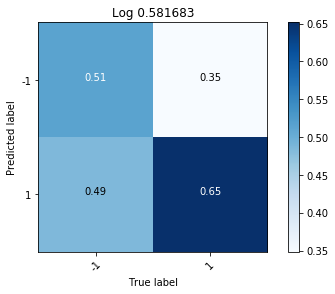

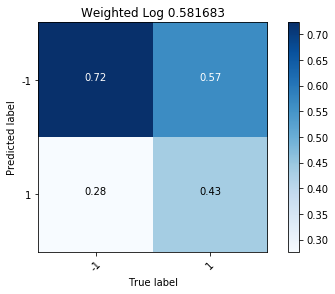

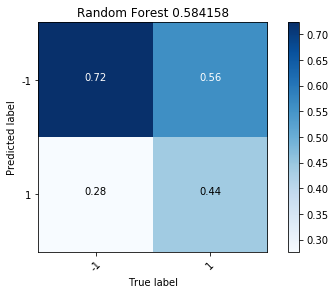

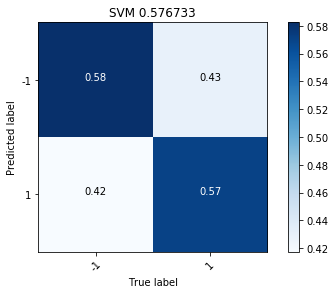

In [75]:
# Logistic Test 
log_test_score = log.score(test_ngrams, labels_test)
log_test_predictions = log.predict(test_ngrams)
plt.figure() 
utils.plot_confusion_matrix(log_test_predictions, labels_test, title='Log {:2f}'.format(log_test_score))

weighted_log_test_score = weighted_log.score(test_ngrams, labels_test)
weighted_log_test_predictions = weighted_log.predict(test_ngrams)
plt.figure() 
utils.plot_confusion_matrix(weighted_log_test_predictions, labels_test, 
                            title='Weighted Log {:2f}'.format(weighted_log_test_score))

# Random Forest Test 
random_forest_score = forest.score(test_ngrams, labels_test)
random_forest_predictions = forest.predict(test_ngrams) 
plt.figure() 
utils.plot_confusion_matrix(random_forest_predictions, labels_test, 
                            title='Random Forest {:2f}'.format(random_forest_score))
# SVM prediction 
svm_score = svm.score(test_ngrams, labels_test)
svm_predictions = svm.predict(test_ngrams)
plt.figure() 
utils.plot_confusion_matrix(svm_predictions, labels_test, title='SVM {:2f}'.format(svm_score))

# Stacked Models

In [ ]:
# Train 
lstm_train_pred = loaded_model.predict({'main_input': int_train_corpus, 'aux_input': train_add})
lstm_val_pred = loaded_model.predict({'main_input': int_val_corpus, 'aux_input': val_add})
lstm_test_pred = loaded_model.predict({'main_input': int_test_corpus, 'aux_input': test_add})
print('Finished LSTM')

In [422]:
tf.reset_default_graph() 
with tf.Session() as sess: 
    saver = tf.train.import_meta_graph('final_cnn_model/7/geniss7-acc0.600503-lr2e-05.meta')
    saver.restore(sess, 'final_cnn_model/7/geniss7-acc0.600503-lr2e-05')
    x = sess.graph.get_tensor_by_name('inputs/input_x:0')
    add_x = sess.graph.get_tensor_by_name('inputs/add_x:0')
    prediction = sess.graph.get_tensor_by_name('prediction/ArgMax:0')
    logit = sess.graph.get_tensor_by_name('fc/dense/BiasAdd:0')
    
    cnn_train_logit_pred_1 = sess.run(logit, feed_dict={x: int_train_corpus, add_x: train_add})
    cnn_train_pred_1 = sess.run(prediction, feed_dict={x: int_train_corpus, add_x: train_add})[:, np.newaxis]
    
    cnn_val_logit_pred_1 = sess.run(logit, feed_dict={x: int_val_corpus, add_x: val_add})
    cnn_val_pred_1 = sess.run(prediction, feed_dict={x: int_val_corpus, add_x: val_add})[:, np.newaxis]
    
    cnn_test_logit_pred_1 = sess.run(logit, feed_dict={x: int_test_corpus, add_x: test_add})
    cnn_test_pred_1 = sess.run(prediction, feed_dict={x: int_test_corpus, add_x: test_add})[:, np.newaxis]

print('Finished CNN 1')    

INFO:tensorflow:Restoring parameters from final_cnn_model/7/geniss7-acc0.600503-lr2e-05
Finished CNN 1


In [382]:
tf.reset_default_graph() 
with tf.Session() as sess: 
    saver = tf.train.import_meta_graph('final_cnn_model/7/geniss7-acc0.582915-lr9e-06.meta')
    saver.restore(sess, 'final_cnn_model/7/geniss7-acc0.582915-lr9e-06')
    x = sess.graph.get_tensor_by_name('inputs/input_x:0')
    add_x = sess.graph.get_tensor_by_name('inputs/add_x:0')
    prediction = sess.graph.get_tensor_by_name('prediction/ArgMax:0')
    logit = sess.graph.get_tensor_by_name('fc/dense/BiasAdd:0')
    
    cnn_train_logit_pred_2 = sess.run(logit, feed_dict={x: int_train_corpus, add_x: train_add})
    cnn_train_pred_2 = sess.run(prediction, feed_dict={x: int_train_corpus, add_x: train_add})[:,np.newaxis]
    
    cnn_val_logit_pred_2 = sess.run(logit, feed_dict={x: int_val_corpus, add_x: val_add})
    cnn_val_pred_2 = sess.run(prediction, feed_dict={x: int_val_corpus, add_x: val_add})[:, np.newaxis]
    
    cnn_test_logit_pred_2 = sess.run(logit, feed_dict={x: int_test_corpus, add_x: test_add})
    cnn_test_pred_2 = sess.run(prediction, feed_dict={x: int_test_corpus, add_x: test_add})[:, np.newaxis]
print('Finished CNN 2')  

tf.reset_default_graph() 
with tf.Session() as sess: 
    saver = tf.train.import_meta_graph('final_cnn_model/7/geniss7-acc0.600502-lr2.7e-05.meta')
    saver.restore(sess, 'final_cnn_model/7/geniss7-acc0.600502-lr2.7e-05')
    x = sess.graph.get_tensor_by_name('inputs/input_x:0')
    add_x = sess.graph.get_tensor_by_name('inputs/add_x:0')
    prediction = sess.graph.get_tensor_by_name('prediction/ArgMax:0')
    logit = sess.graph.get_tensor_by_name('fc/dense/BiasAdd:0')
    
    cnn_train_logit_pred_3 = sess.run(logit, feed_dict={x: int_train_corpus, add_x: train_add})
    cnn_train_pred_3 = sess.run(prediction, feed_dict={x: int_train_corpus, add_x: train_add})[:, np.newaxis]
    
    cnn_val_logit_pred_3 = sess.run(logit, feed_dict={x: int_val_corpus, add_x: val_add})
    cnn_val_pred_3 = sess.run(prediction, feed_dict={x: int_val_corpus, add_x: val_add})[:, np.newaxis]
    
    cnn_test_logit_pred_3 = sess.run(logit, feed_dict={x: int_test_corpus, add_x: test_add})
    cnn_test_pred_3 = sess.run(prediction, feed_dict={x: int_test_corpus, add_x: test_add})[:, np.newaxis]
print('Finished CNN 3')  

INFO:tensorflow:Restoring parameters from final_cnn_model/7/geniss7-acc0.582915-lr9e-06
Finished CNN 2
INFO:tensorflow:Restoring parameters from final_cnn_model/7/geniss7-acc0.600502-lr2.7e-05
Finished CNN 3


In [387]:
log_train_pred = log.predict(train_ngrams)[:, np.newaxis]
log_val_pred = log.predict(val_ngrams)[:, np.newaxis]
log_test_pred = log.predict(test_ngrams)[:,np.newaxis]

log_train_logit_pred = log.predict_proba(train_ngrams)
log_val_logit_pred = log.predict_proba(val_ngrams)
log_test_logit_pred = log.predict_proba(test_ngrams)
print('Finished Log')

weighted_log_train_pred = weighted_log.predict(train_ngrams)[:, np.newaxis]
weighted_log_val_pred = weighted_log.predict(val_ngrams)[:, np.newaxis]
weighted_log_test_pred = weighted_log.predict(test_ngrams)[:, np.newaxis]

weighted_log_train_logit_pred = weighted_log.predict_proba(train_ngrams)
weighted_log_val_logit_pred = weighted_log.predict_proba(val_ngrams)
weighted_log_test_logit_pred = weighted_log.predict_proba(test_ngrams)
print('Finished Weighted Log')

# random_forest_train_pred = forest.predict(train_ngrams)[:, np.newaxis]
# random_forest_val_pred = forest.predict(val_ngrams)[:, np.newaxis]
# print('Finished Random Forest')

# svm_train_pred = svm.predict(train_ngrams)[:, np.newaxis]
# svm_val_pred = svm.predict(val_ngrams)[:, np.newaxis]
# print('Finished SVM')

# gb_train_pred = gradboost.predict(train_ngrams)[:, np.newaxis]
# gb_val_pred = gradboost.predict(val_ngrams)[:, np.newaxis]
# gb_test_pred = gradboost.predict(test_ngrams)[:, np.newaxis]
# print('Finished Gradient Boost')

# gnb_train_pred = gnb.predict(train_ngrams)[:, np.newaxis]
# gnb_val_pred = gnb.predict(val_ngrams)[:, np.newaxis]
# gnb_test_pred = gnb.predict(test_ngrams)[:, np.newaxis]
# print('Finished Naive Bayes')

bnb_train_pred = nb.predict(train_ngrams)[:, np.newaxis]
bnb_val_pred = nb.predict(val_ngrams)[:, np.newaxis]
bnb_test_pred = nb.predict(test_ngrams)[:, np.newaxis]

bnb_train_logit_pred = nb.predict_proba(train_ngrams)
bnb_val_logit_pred = nb.predict_proba(val_ngrams)
bnb_test_logit_pred = nb.predict_proba(test_ngrams)
print('Finished Bernoulli Naive Bayes')

Finished Log
Finished Weighted Log
Finished Bernoulli Naive Bayes


In [357]:
lstm_train = np.argmax(lstm_train_pred, 1)[:, np.newaxis]
lstm_val = np.argmax(lstm_val_pred, 1)[:, np.newaxis]
lstm_test = np.argmax(lstm_test_pred, 1)[:, np.newaxis]

lstm_train[lstm_train==0] = -1
lstm_val[lstm_val==0] = -1
lstm_test[lstm_test==0] = -1

In [307]:
random_forest_test_pred = random_forest_predictions[:,np.newaxis]

svm_test_pred = svm_predictions[:, np.newaxis]

log_test_pred = log_test_predictions[:, np.newaxis]

weighted_log_test_pred = weighted_log_test_predictions[:, np.newaxis]

Train Acc: 0.8451541032305978 Val Acc: 0.585427135678392
Coef: [[ 1.34076047 -0.56292196 -0.19369259 -0.66203634  0.83770334  1.13829786
   1.27518045]]
Normalized confusion matrix
[[0.58064516 0.41037736]
 [0.41935484 0.58962264]]


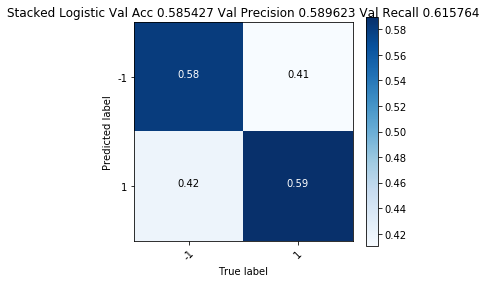

In [425]:
train_pred = np.concatenate((lstm_train, log_train_pred, weighted_log_train_pred, 
                             cnn_train_pred_1, cnn_train_pred_2, cnn_train_pred_3, bnb_train_pred), axis=1)

val_pred = np.concatenate((lstm_val, log_val_pred, weighted_log_val_pred, 
                           cnn_val_pred_1, cnn_val_pred_2, cnn_val_pred_3, bnb_val_pred), axis=1)

test_pred = np.concatenate((lstm_test, log_test_pred, weighted_log_test_pred, 
                            cnn_test_pred_1, cnn_test_pred_2, cnn_test_pred_3, bnb_test_pred), axis=1) 

stacked_logistic = LogisticRegression(random_state=10, penalty='l1')
stacked_logistic.fit(train_pred, labels_train)
stacked_log_train_acc = stacked_logistic.score(train_pred, labels_train)
stacked_log_val_acc = stacked_logistic.score(val_pred, labels_val)

stacked_log_prediction = stacked_logistic.predict(train_pred)
stacked_log_prediction_val = stacked_logistic.predict(val_pred)

stacked_log_precision = sklearn.metrics.precision_score(stacked_log_prediction_val, labels_val)
stacked_log_recall = sklearn.metrics.recall_score(stacked_log_prediction_val, labels_val)

print('Train Acc:', stacked_log_train_acc, 'Val Acc:', stacked_log_val_acc)
print('Coef:', stacked_logistic.coef_)
utils.plot_confusion_matrix(stacked_log_prediction_val, labels_val, 
                           title='Stacked Logistic Val Acc {:2f} Val Precision {:2f} Val Recall {:2f}'.format(stacked_log_val_acc, 
                                                                                                             stacked_log_precision, 
                                                                                                             stacked_log_recall))

Train Acc: 0.8083921277385815
Normalized confusion matrix
[[0.47849462 0.27830189]
 [0.52150538 0.72169811]]


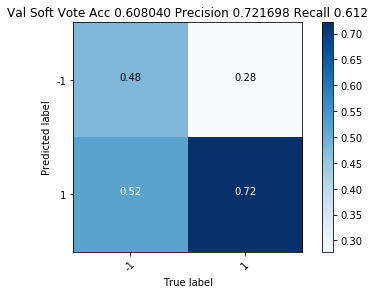

In [424]:
# SOFT MAJORITY VOTING 
# Training 
estimators = [lstm_train_pred, cnn_train_logit_pred_1, cnn_train_logit_pred_2, cnn_train_logit_pred_3, 
              log_train_logit_pred, weighted_log_train_logit_pred, bnb_train_logit_pred]
voting_train_prediction = np.argmax(np.sum(estimators, axis=0), 1)
voting_train_prediction[voting_train_prediction==0] = -1 
train_acc = np.sum(voting_train_prediction==labels_train)/len(labels_train)
print('Train Acc:', train_acc)

# Validation 
val_estimators = [lstm_val_pred, cnn_val_logit_pred_1, cnn_val_logit_pred_2, cnn_val_logit_pred_3, 
              log_val_logit_pred, weighted_log_val_logit_pred, bnb_val_logit_pred]
voting_val_prediction = np.argmax(np.sum(val_estimators, axis=0), 1)
voting_val_prediction[voting_val_prediction==0] = -1 
val_acc = np.sum(voting_val_prediction==labels_val)/len(labels_val)
val_precision = sklearn.metrics.precision_score(voting_val_prediction, labels_val)
val_recall = sklearn.metrics.recall_score(voting_val_prediction, labels_val)
plt.figure()
utils.plot_confusion_matrix(voting_val_prediction, labels_val, 
                            title='Val Soft Vote Acc {:2f} Precision {:2f} Recall {}'.format(val_acc, 
                                                                                             val_precision, 
                                                                                             val_recall))

# Topic number to topic label matching 

In [88]:
with open('data/bb2topic.pkl', 'rb') as topic_p: 
    topic_labels = pickle.load(topic_p)

In [92]:
train_data['topic_label'] = train_data['caseid'].apply(lambda x: topic_labels[x])

In [93]:
for topic in topics: 
    print('TOPIC {}'.format(topic))
    print(set(train_data[train_data['geniss1']==topic]['topic_label']))
    print('\n')

TOPIC 1
{'Gambling & Lotteries Law', '', 'Alcohol & Beverage', 'Criminal Law'}


TOPIC 2
{'Habeas Corpus', "Prisoners' Rights", 'Civil Rights', 'Health Law'}


TOPIC 4
{'Legal Malpractice', 'Civil Procedure', 'Government', 'Government Employees', 'Appellate Procedure', 'Evidence'}


TOPIC 6
{'Employee Benefits', 'Employment Law', "Workers' Compensation", 'Labor Law'}


TOPIC 7
{'International Trade Law', 'Torts', 'Trademark Law', 'Real Property', 'Corporate Law', 'Banking & Finance', 'Motor Vehicles & Traffic Law', 'Consumer Law', 'Land Use Planning & Zoning', 'Bankruptcy Law', 'Mortgages & Liens', 'Admiralty & Maritime', 'Construction Law', 'Damages & Remedies', 'Personal Property', 'Patent Law', 'Contracts', 'Energy Law', 'Debtor Creditor', 'Trade Secrets', 'Securities Law', 'Copyright Law', 'Agency', 'Franchise Law', 'Landlord & Tenant', 'Medical Malpractice', 'Mergers & Acquisitions', 'Wills, Trusts & Estates', 'Technology Law', 'Products Liability', 'Intellectual Property Treaties

# Coefficients for linear models 

In [516]:
log.coef_

array([[-2.59063891,  0.        ,  0.        , ...,  0.26066645,
        -0.40185297, -0.26397306]])

In [549]:
import csv 
with open('features.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['feature', 'index'])
    for feature,idx in vectorizer.vocabulary_.items(): 
        writer.writerow([str(feature), idx])

In [550]:
features = pd.read_csv('features.csv')
features.head()
# Add additional features 
# additional_features = ['caseid', 'Affirmed', 'AffirmedInPart', 'Reversed', 'ReversedInPart', 
#                       'Vacated', 'VacatedInPart', 'Remanded']
# i = max(features['index'])
# for f in additional_features: 
#     features.append({'feature':f, 'index':i+1}, ignore_index=True)
#     i = i+1
# features.info() 

,feature,index
0,appeal,5665
1,review,26779
2,district,13593
3,court,10833
4,entry,14755


In [551]:
features[pd.isnull(features['feature'])]

,feature,index
7208,NaN,22005


In [527]:
features['log_coef'] = log.coef_

ValueError: Length of values does not match length of index